### Multi-Class Model for Kaggle Tabular Playground Series December 2021 Using TensorFlow Decision Forests
### David Lowe
### November 24, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground December 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. This dataset is based off of the original Forest Cover Type Prediction competition.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an accuracy benchmark of 0.9599 on the validation dataset. The final model processed the validation dataset with a final accuracy score of 0.9627. When we applied the finalized model to Kaggle's test dataset, the model achieved an accuracy score of 0.9535.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 December Data Set

Dataset ML Model: Multi-Class classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-dec-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-dec-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Installing TFDF might be necessary when using the script with Google Colab
# !pip install tensorflow_decision_forests

In [3]:
# For managing screen output when using the script with Google Colab
# !pip install wurlitzer

In [4]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [5]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [6]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [7]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [8]:
# Set the random seed number for reproducible results
RNG_SEED = 88

In [9]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-12-20 21:23:55.121669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 21:23:55.121745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# try:
#   from wurlitzer import sys_pipes
# except:
#   from colabtools.googlelog import CaptureLog as sys_pipes

# from IPython.core.magic import register_line_magic
# from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [11]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [12]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-12-20 21:24:00.938022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-20 21:24:00.938084: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 21:24:00.938127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4560282a5817): /proc/driver/nvidia/version does not exist


In [13]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [14]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [15]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [16]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021dec/train.csv

In [17]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   0       3189      40      8                                30   
1   1       3026     182      5                               280   
2   2       3106      13      7                               351   
3   3       3022     276     13                               192   
4   4       2906     186     13                               266   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              13                             3270   
1                              29                             3270   
2                              37                             2914   
3                              16                             3034   
4                              22                             2916   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            206             234            193  ...            0   
1            233          

In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 56 columns):
 #   Column                              Dtype
---  ------                              -----
 0   Id                                  int64
 1   Elevation                           int64
 2   Aspect                              int64
 3   Slope                               int64
 4   Horizontal_Distance_To_Hydrology    int64
 5   Vertical_Distance_To_Hydrology      int64
 6   Horizontal_Distance_To_Roadways     int64
 7   Hillshade_9am                       int64
 8   Hillshade_Noon                      int64
 9   Hillshade_3pm                       int64
 10  Horizontal_Distance_To_Fire_Points  int64
 11  Wilderness_Area1                    int64
 12  Wilderness_Area2                    int64
 13  Wilderness_Area3                    int64
 14  Wilderness_Area4                    int64
 15  Soil_Type1                          int64
 16  Soil_Type2                          

In [19]:
print(df_dataset_import.describe())

                 Id     Elevation        Aspect         Slope  \
count  4.000000e+06  4.000000e+06  4.000000e+06  4.000000e+06   
mean   2.000000e+06  2.980192e+03  1.515857e+02  1.509754e+01   
std    1.154701e+06  2.890482e+02  1.099611e+02  8.546731e+00   
min    0.000000e+00  1.773000e+03 -3.300000e+01 -3.000000e+00   
25%    9.999998e+05  2.760000e+03  6.000000e+01  9.000000e+00   
50%    2.000000e+06  2.966000e+03  1.230000e+02  1.400000e+01   
75%    2.999999e+06  3.217000e+03  2.470000e+02  2.000000e+01   
max    3.999999e+06  4.383000e+03  4.070000e+02  6.400000e+01   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      4.000000e+06                    4.000000e+06   
mean                       2.713154e+02                    5.166262e+01   
std                        2.265497e+02                    6.821597e+01   
min                       -9.200000e+01                   -3.170000e+02   
25%                        1.100000e+02

In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [21]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Cover_Type').size())

Cover_Type
1    1468136
2    2262087
3     195712
4        377
5          1
6      11426
7      62261
dtype: int64


### 1.d) Data Cleaning

In [22]:
# Dropping features withunique values or no variations
df_dataset_import.drop(columns=['Id','Soil_Type7','Soil_Type15'], inplace=True)

#Dropping class with the least number of rows associated with
df_dataset_import = df_dataset_import[df_dataset_import['Cover_Type'] != 5]

# Convert columns from one data type to another
float_feature_list = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
                      'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                      'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
for feature in float_feature_list:
    df_dataset_import[feature] = df_dataset_import[feature].astype('float')

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Cover_Type':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     3189.0    40.0    8.0                              30.0   
1     3026.0   182.0    5.0                             280.0   
2     3106.0    13.0    7.0                             351.0   
3     3022.0   276.0   13.0                             192.0   
4     2906.0   186.0   13.0                             266.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                            13.0                           3270.0   
1                            29.0                           3270.0   
2                            37.0                           2914.0   
3                            16.0                           3034.0   
4                            22.0                           2916.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          206.0           234.0          193.0   
1          233.0           240.0          106.0   
2          208.0           234.0   

In [23]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999999 entries, 0 to 3999999
Data columns (total 53 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Elevation                           float64
 1   Aspect                              float64
 2   Slope                               float64
 3   Horizontal_Distance_To_Hydrology    float64
 4   Vertical_Distance_To_Hydrology      float64
 5   Horizontal_Distance_To_Roadways     float64
 6   Hillshade_9am                       float64
 7   Hillshade_Noon                      float64
 8   Hillshade_3pm                       float64
 9   Horizontal_Distance_To_Fire_Points  float64
 10  Wilderness_Area1                    int64  
 11  Wilderness_Area2                    int64  
 12  Wilderness_Area3                    int64  
 13  Wilderness_Area4                    int64  
 14  Soil_Type1                          int64  
 15  Soil_Type2                          int64  
 16  

In [24]:
print(df_dataset_import.describe())

          Elevation        Aspect         Slope  \
count  3.999999e+06  3.999999e+06  3.999999e+06   
mean   2.980192e+03  1.515857e+02  1.509753e+01   
std    2.890482e+02  1.099611e+02  8.546724e+00   
min    1.773000e+03 -3.300000e+01 -3.000000e+00   
25%    2.760000e+03  6.000000e+01  9.000000e+00   
50%    2.966000e+03  1.230000e+02  1.400000e+01   
75%    3.217000e+03  2.470000e+02  2.000000e+01   
max    4.383000e+03  4.070000e+02  6.400000e+01   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      3.999999e+06                    3.999999e+06   
mean                       2.713155e+02                    5.166261e+01   
std                        2.265497e+02                    6.821597e+01   
min                       -9.200000e+01                   -3.170000e+02   
25%                        1.100000e+02                    4.000000e+00   
50%                        2.130000e+02                    3.100000e+01   
75%            

In [25]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0


In [26]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
1    1468136
2    2262087
3     195712
4        377
6      11426
7      62261
dtype: int64


### 1.e) Splitting Data into Sets

In [27]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (3999999, 53) df_features_train.shape: (3999999, 52) df_target_train.shape: (3999999,)


### 1.f) Set up the parameters for data visualization

In [28]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [29]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [30]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

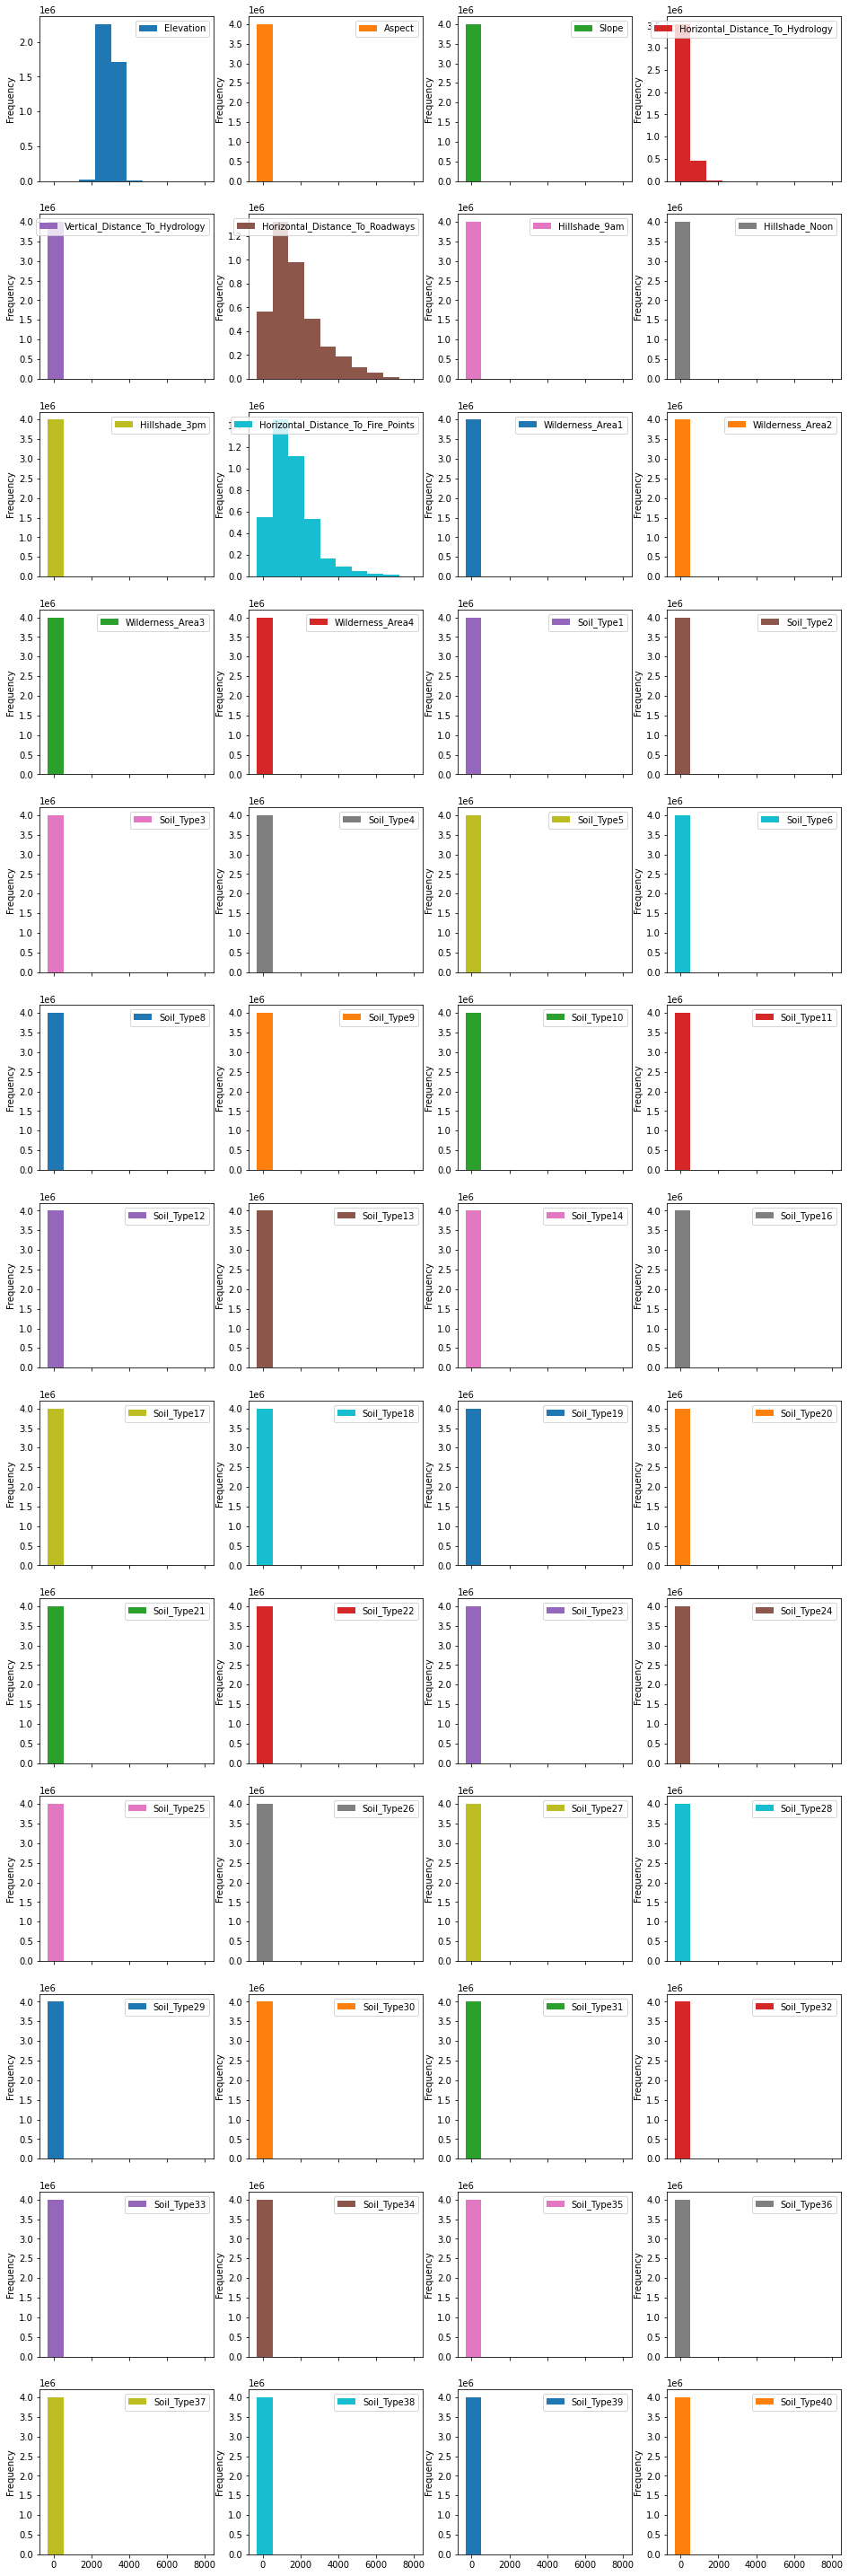

In [31]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

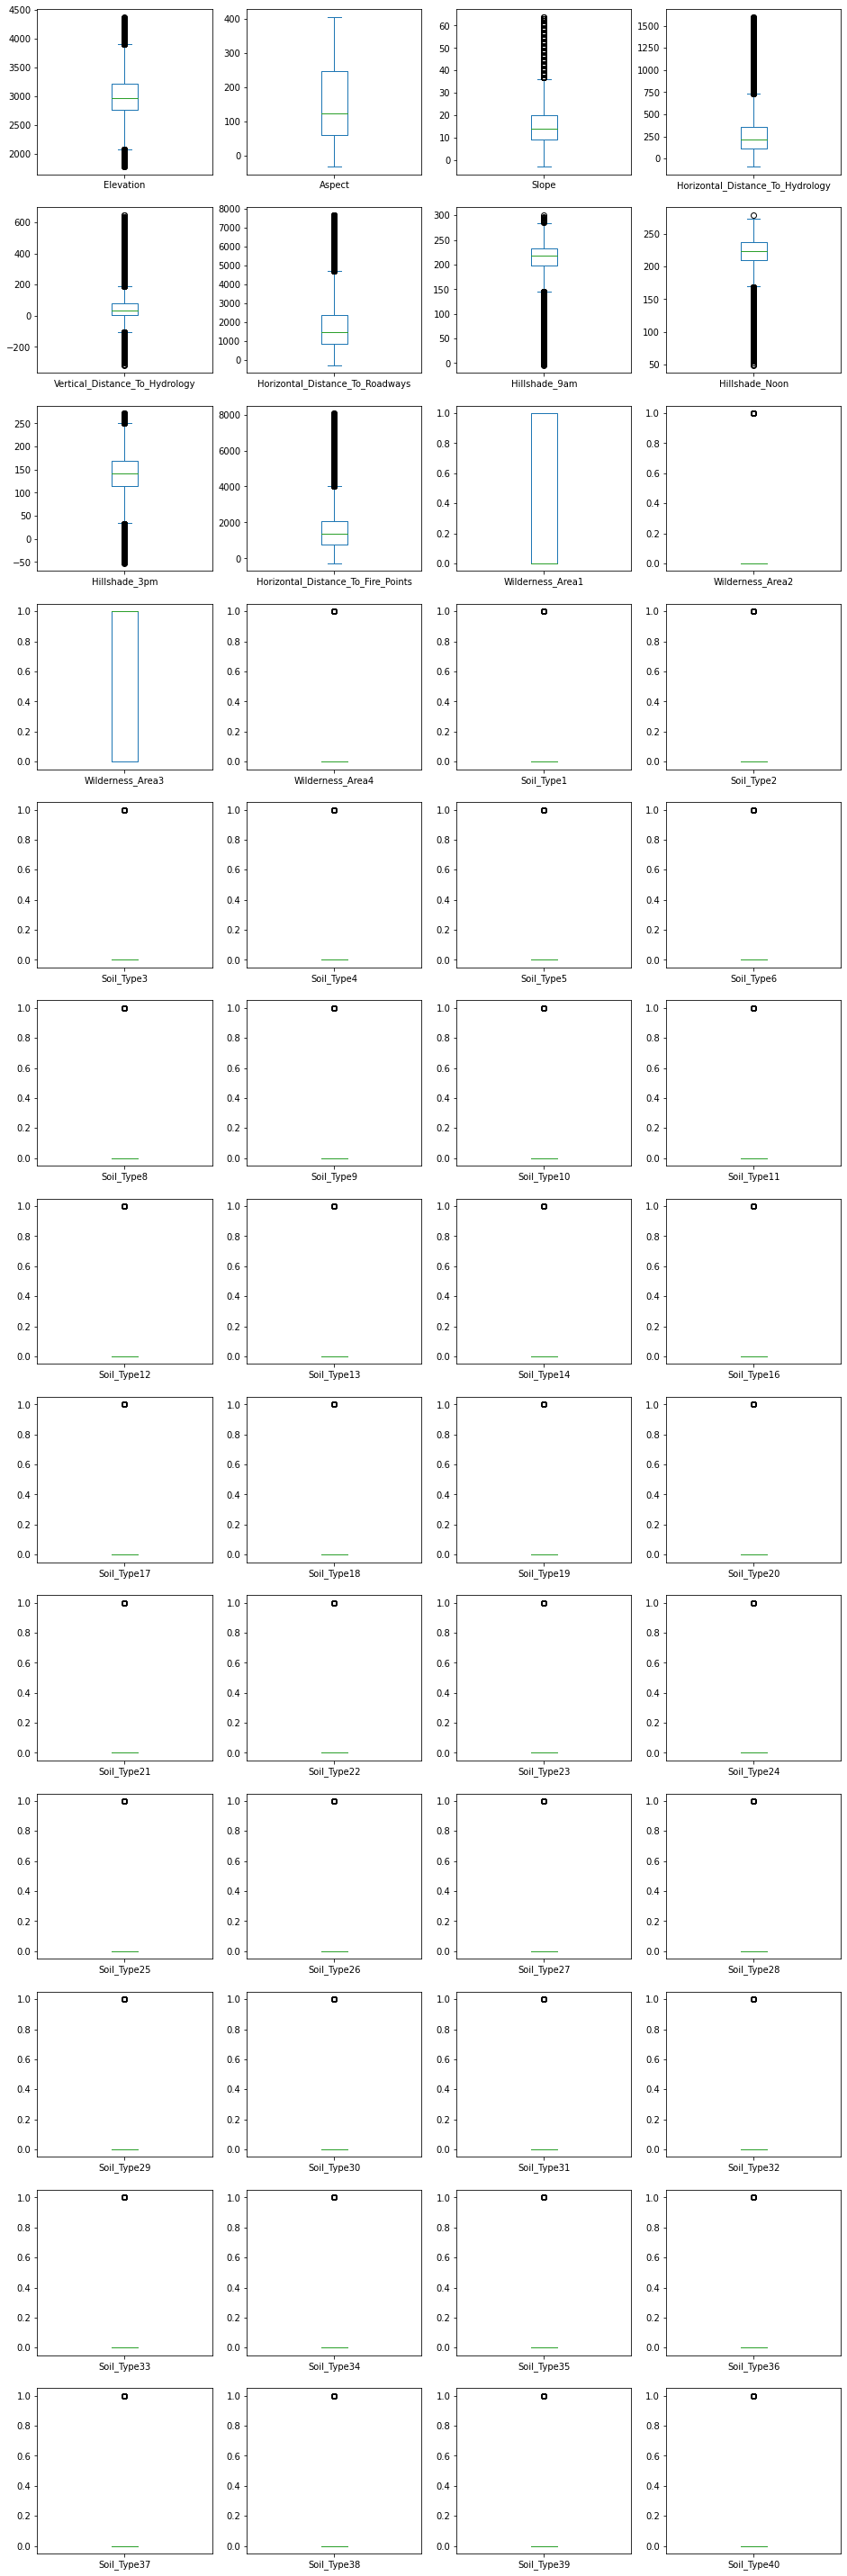

In [32]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [33]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [34]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [36]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (3599999, 53) df_dataset_valid.shape: (400000, 53)


In [37]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task=tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task=tfdf.keras.Task.CLASSIFICATION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [38]:
# Define the baseline model for benchmarking
START_TIME_MODULE = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - START_TIME_MODULE), '\n')

56248/56250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

56250/56250 [==============================] - 5385s 95ms/step
Model training time: 1:29:59.149836 



In [39]:
RF_eval = RF_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

6250/6250 [==============================] - 176s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9392 - sparse_categorical_crossentropy: 0.1877

loss: 0.0000
accuracy: 0.9392
sparse_categorical_crossentropy: 0.1877


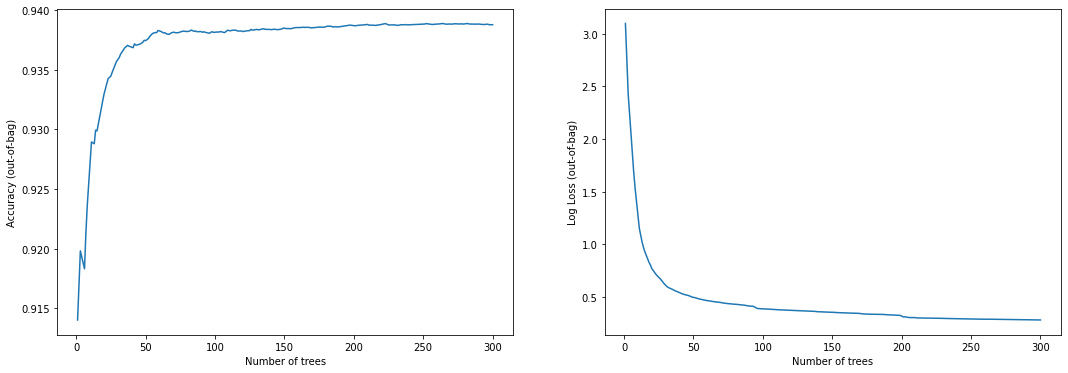

In [40]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [41]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(RF_model)

### 3.c) Train and Evaluate the Decision Trees Model

In [42]:
# Define the baseline model for benchmarking
START_TIME_MODULE = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - START_TIME_MODULE), '\n')

56247/56250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

56250/56250 [==============================] - 940s 17ms/step


[INFO cart.cc:375] 11783 nodes before pruning. 3529 nodes after pruning.
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpo3p21r1l
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 1 root(s), 3529 node(s), and 48 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:15:47.000400 



In [43]:
CART_eval = CART_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

6250/6250 [==============================] - 89s 14ms/step - loss: 0.0000e+00 - accuracy: 0.8954 - sparse_categorical_crossentropy: 0.2325

loss: 0.0000
accuracy: 0.8954
sparse_categorical_crossentropy: 0.2325


In [44]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(CART_model)

### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [45]:
# Define the baseline model for benchmarking
START_TIME_MODULE = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - START_TIME_MODULE), '\n')

56250/56250 [==============================] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

56250/56250 [==============================] - 41059s 730ms/step


[INFO decision_forest.cc:590] Model loaded with 2400 root(s), 146442 node(s), and 52 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 11:24:29.416476 



In [46]:
GBT_eval = GBT_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

6250/6250 [==============================] - 237s 38ms/step - loss: 0.0000e+00 - accuracy: 0.9585 - sparse_categorical_crossentropy: 0.1880

loss: 0.0000
accuracy: 0.9585
sparse_categorical_crossentropy: 0.1880


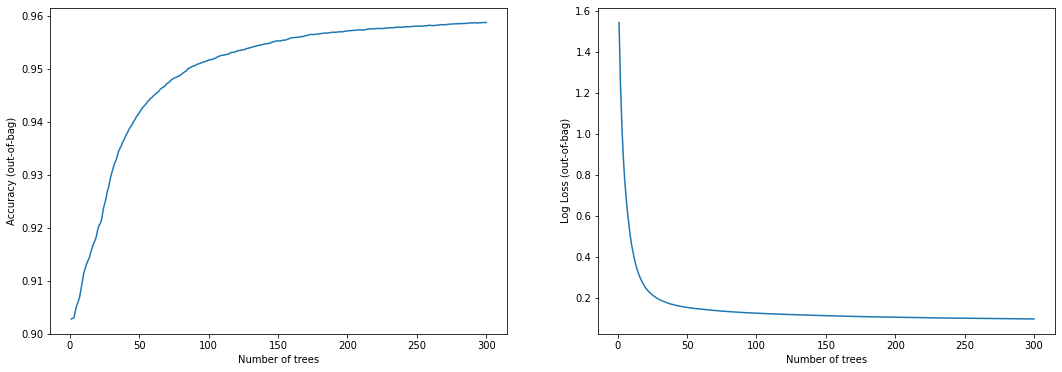

In [47]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [48]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(GBT_model)

In [49]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [50]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
for num_trees in [150, 300, 500]:
    # Define the baseline model for benchmarking
    START_TIME_MODULE = datetime.now()
    model_tune = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, task=tfdf.keras.Task.CLASSIFICATION)
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - START_TIME_MODULE), '\n')

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

6250/6250 [==============================] - 164s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9550 - sparse_categorical_crossentropy: 0.1698

loss: 0.0000
accuracy: 0.9550
sparse_categorical_crossentropy: 0.1698
Model optimization time: 5:46:53.073485 



[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

6250/6250 [==============================] - 237s 38ms/step - loss: 0.0000e+00 - accuracy: 0.9585 - sparse_categorical_crossentropy: 0.1557

loss: 0.0000
accuracy: 0.9585
sparse_categorical_crossentropy: 0.1557
Model optimization time: 11:33:37.406646 



[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 56250
[INFO kernel.cc:393] Number of examples: 3599999
[INFO kernel.cc:759] Dataset:
Number of records: 3599999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.588 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.16 min:1773 max:4383 sd:289.01
	2: "Hillshade_3pm" NUMERICAL mean:140.801 min:-53 max:272 sd:43.6985
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.7564
	4: "Hillshade_Noon" NUMERICAL mean:221.064 min:49 max:279 sd:22.2269
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.63 min:-277 max:8075 sd:1127.73
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.355 min:-92 max:1602 sd:226.596
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.42 min:-287 max:7666 sd:1315.6

6250/6250 [==============================] - 361s 58ms/step - loss: 0.0000e+00 - accuracy: 0.9599 - sparse_categorical_crossentropy: 0.1450

loss: 0.0000
accuracy: 0.9599
sparse_categorical_crossentropy: 0.1450
Model optimization time: 19:01:38.018897 



In [52]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [53]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [54]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target', task=tfdf.keras.Task.CLASSIFICATION)

In [56]:
# Define the baseline model for benchmarking
START_TIME_MODULE = datetime.now()
final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=500, task=tfdf.keras.Task.CLASSIFICATION)
final_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - START_TIME_MODULE), '\n')

62497/62500 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 62500
[INFO kernel.cc:393] Number of examples: 3999999
[INFO kernel.cc:759] Dataset:
Number of records: 3999999
Number of columns: 53

Number of columns by type:
	NUMERICAL: 52 (98.1132%)
	CATEGORICAL: 1 (1.88679%)

Columns:

NUMERICAL: 52 (98.1132%)
	0: "Aspect" NUMERICAL mean:151.586 min:-33 max:407 sd:109.961
	1: "Elevation" NUMERICAL mean:2980.19 min:1773 max:4383 sd:289.048
	2: "Hillshade_3pm" NUMERICAL mean:140.811 min:-53 max:272 sd:43.6986
	3: "Hillshade_9am" NUMERICAL mean:211.838 min:-4 max:301 sd:30.76
	4: "Hillshade_Noon" NUMERICAL mean:221.061 min:49 max:279 sd:22.2313
	5: "Horizontal_Distance_To_Fire_Points" NUMERICAL mean:1581.41 min:-277 max:8075 sd:1127.61
	6: "Horizontal_Distance_To_Hydrology" NUMERICAL mean:271.315 min:-92 max:1602 sd:226.55
	7: "Horizontal_Distance_To_Roadways" NUMERICAL mean:1766.64 min:-287 max:7666 sd:1315.61


62500/62500 [==============================] - 76876s 1s/step


[INFO decision_forest.cc:590] Model loaded with 4000 root(s), 240862 node(s), and 52 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 21:21:30.141562 



In [57]:
final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (52):
	Aspect
	Elevation
	Hillshade_3pm
	Hillshade_9am
	Hillshade_Noon
	Horizontal_Distance_To_Fire_Points
	Horizontal_Distance_To_Hydrology
	Horizontal_Distance_To_Roadways
	Slope
	Soil_Type1
	Soil_Type10
	Soil_Type11
	Soil_Type12
	Soil_Type13
	Soil_Type14
	Soil_Type16
	Soil_Type17
	Soil_Type18
	Soil_Type19
	Soil_Type2
	Soil_Type20
	Soil_Type21
	Soil_Type22
	Soil_Type23
	Soil_Type24
	Soil_Type25
	Soil_Type26
	Soil_Type27
	Soil_Type28
	Soil_Type29
	Soil_Type3
	Soil_Type30
	Soil_Type31
	Soil_Type32
	Soil_Type33
	Soil_Type34
	Soil_Type35
	Soil_Type36
	Soil_Type37
	Soil_Type38
	Soil_Type39
	Soil_Type4
	Soil_Type4

### 5.b) Load Test Dataset and Make Predictions

In [58]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021dec/test.csv

In [59]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

        Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  4000000       2763      78     20                               377   
1  4000001       2826     153     11                               264   
2  4000002       2948      57     19                                56   
3  4000003       2926     119      6                               158   
4  4000004       2690      10      4                                38   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              88                             3104   
1                              39                              295   
2                              44                              852   
3                             134                             2136   
4                             108                             3589   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type31  \
0            218             213            195  ...            0

In [60]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['Id'] = df_features_test['Id']
print(df_kaggle_submission.head())

        Id
0  4000000
1  4000001
2  4000002
3  4000003
4  4000004


In [61]:
# Dropping features
df_features_test.drop(columns=['Id','Soil_Type7','Soil_Type15'], inplace=True)

for feature in float_feature_list:
    df_features_test[feature] = df_features_test[feature].astype('float')

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2763.0    78.0   20.0                             377.0   
1     2826.0   153.0   11.0                             264.0   
2     2948.0    57.0   19.0                              56.0   
3     2926.0   119.0    6.0                             158.0   
4     2690.0    10.0    4.0                              38.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                            88.0                           3104.0   
1                            39.0                            295.0   
2                            44.0                            852.0   
3                           134.0                           2136.0   
4                           108.0                           3589.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          218.0           213.0          195.0   
1          219.0           238.0          148.0   
2          202.0           217.0   

In [62]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task=tfdf.keras.Task.CLASSIFICATION)

In [66]:
# Make batched predictions
test_predictions = np.argmax(final_model.predict(tfds_test), axis=-1)
print(test_predictions)

[2 2 2 ... 2 1 3]


In [67]:
df_kaggle_submission['Cover_Type'] = test_predictions
print(df_kaggle_submission.head())

        Id  Cover_Type
0  4000000           2
1  4000001           2
2  4000002           2
3  4000003           2
4  4000004           2


In [68]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211224-0639.csv


In [69]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [70]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 3 days, 9:15:54.862652
